In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")

%matplotlib inline
DATA_FOLDER = 'data/'
training_filename = 'training.csv'

In [2]:
df = pd.read_csv(DATA_FOLDER + training_filename)

## Basic Exploration

In [3]:
df.head()

,id_policy,year,pol_no_claims_discount,pol_coverage,pol_duration,pol_sit_duration,pol_pay_freq,pol_payd,pol_usage,drv_sex1,...,vh_make_model,vh_age,vh_fuel,vh_type,vh_speed,vh_value,vh_weight,population,town_surface_area,claim_amount
0,PL000000,1.0,0.332,Med2,5,1,Monthly,No,WorkPrivate,M,...,aparvvfowrjncdhp,8.0,Gasoline,Tourism,174.0,11040.0,1143.0,1270.0,33.1,0.0
1,PL042495,1.0,0.000,Med2,6,1,Monthly,No,WorkPrivate,M,...,aparvvfowrjncdhp,10.0,Diesel,Tourism,174.0,11040.0,1143.0,1290.0,51.3,0.0
2,PL042496,1.0,0.196,Med1,2,1,Yearly,Yes,Retired,M,...,iwhqpdfuhrsxyqxe,8.0,Diesel,Commercial,150.0,14159.0,1193.0,1020.0,262.8,0.0
3,PL042497,1.0,0.000,Med2,8,5,Yearly,No,WorkPrivate,F,...,kvcddisqpkysmvvo,4.0,Gasoline,Tourism,149.0,17233.0,1012.0,180.0,219.7,0.0
4,PL042498,1.0,0.000,Med1,2,2,Yearly,No,Retired,F,...,tdgkjlphosocwbgu,13.0,Gasoline,Tourism,200.0,19422.0,1315.0,30.0,70.3,0.0


In [4]:
print("Rows: {}\nFeatures: {}".format(*df.shape))
print(df.dtypes)

Rows: 228216
Features: 26
id_policy                  object
year                      float64
pol_no_claims_discount    float64
pol_coverage               object
pol_duration                int64
pol_sit_duration            int64
pol_pay_freq               object
pol_payd                   object
pol_usage                  object
drv_sex1                   object
drv_age1                  float64
drv_age_lic1              float64
drv_drv2                   object
drv_sex2                   object
drv_age2                  float64
drv_age_lic2              float64
vh_make_model              object
vh_age                    float64
vh_fuel                    object
vh_type                    object
vh_speed                  float64
vh_value                  float64
vh_weight                 float64
population                float64
town_surface_area         float64
claim_amount              float64
dtype: object


In [5]:
categorical = df.dtypes[df.dtypes == 'object'].drop('id_policy')
non_categorical = df.dtypes[df.dtypes != 'object']

#### Target Var

As expected, the claims follow the pareto principle. Most people (89%) have 0 claims throughout.

In [6]:
df['claim_amount'].describe()

count    228216.000000
mean        114.181250
std         725.125386
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      141828.260000
Name: claim_amount, dtype: float64

In [7]:
zero_claims_percentage = ((df['claim_amount'] == 0).sum() / len(df))*100
zero_claims_percentage

89.79387948259544

Distributions for people who actually made claims

count     23292.000000
mean       1118.752708
std        2007.027858
min           0.020000
25%         324.287500
50%         690.525000
75%        1288.790000
max      141828.260000
Name: claim_amount, dtype: float64


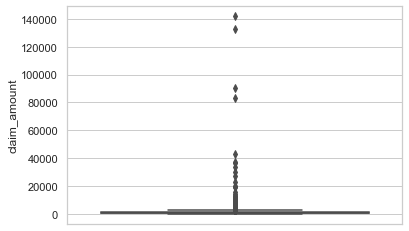

In [8]:
claims = df['claim_amount'][df['claim_amount']>0]
print(claims.describe())
sns.boxplot(y=claims, orient='v')

#### Categorical on their own

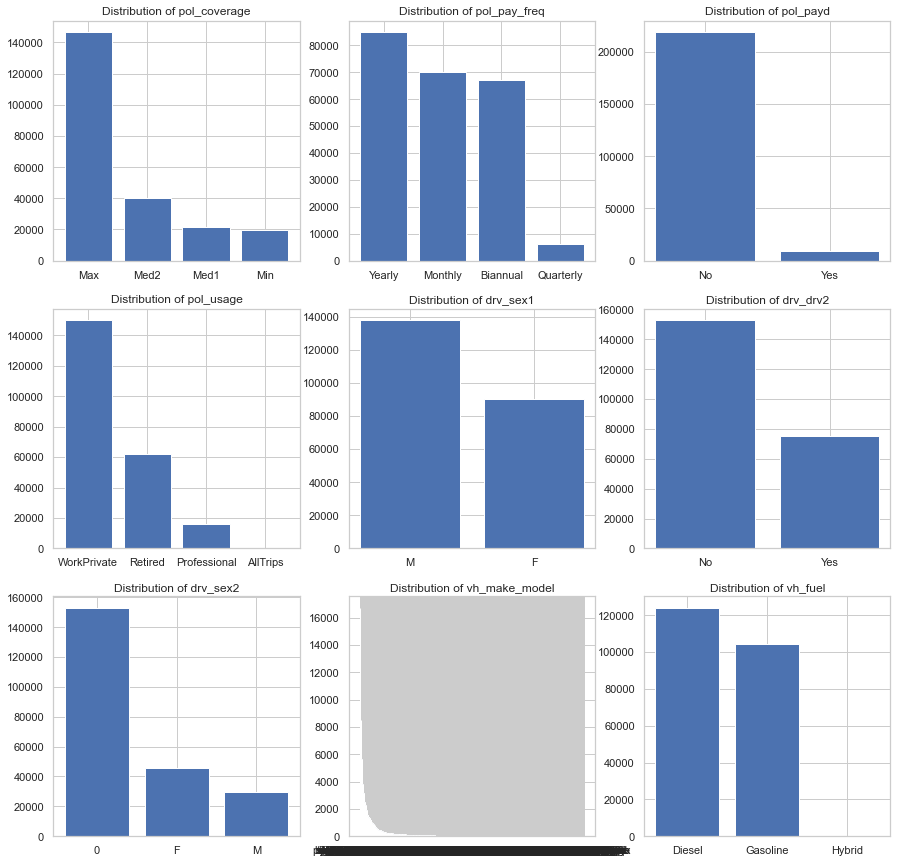

In [9]:
def plot_categorical_var_distribution(df, cat_vars, num_cols_per_row=3):
    num_rows = len(cat_vars) // num_cols_per_row
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols_per_row, figsize=(15,15))
    counter = 0
    for row in ax:
        for col in row:
            colname = cat_vars[counter]
            x = df[colname].value_counts(dropna=False)
            col.bar(x.index,
                    height=x.values)
            col.title.set_text('Distribution of {}'.format(colname))
            counter += 1
    plt.show()

plot_categorical_var_distribution(df, categorical.index)

#### Numerical Variable Distributions

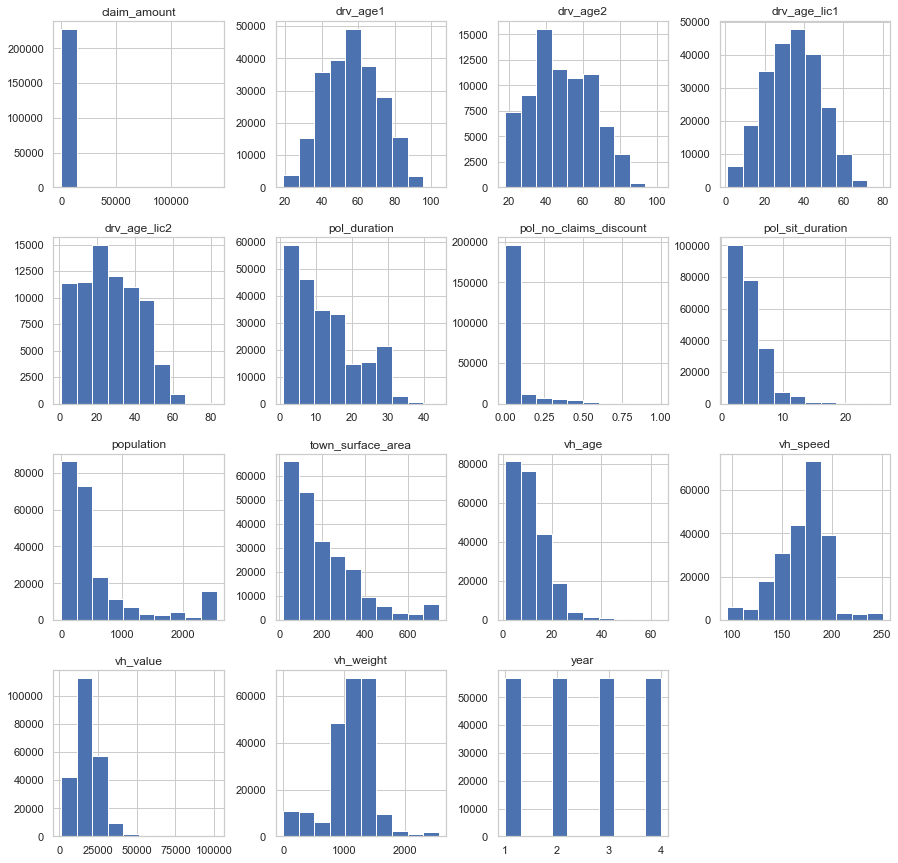

In [10]:
_ = df[non_categorical.index].hist(figsize=(15,15))

## More Specific Comparisons: Variables to target

Numeric vars correlation, its observed that claim amount is linked to speed, value, weight

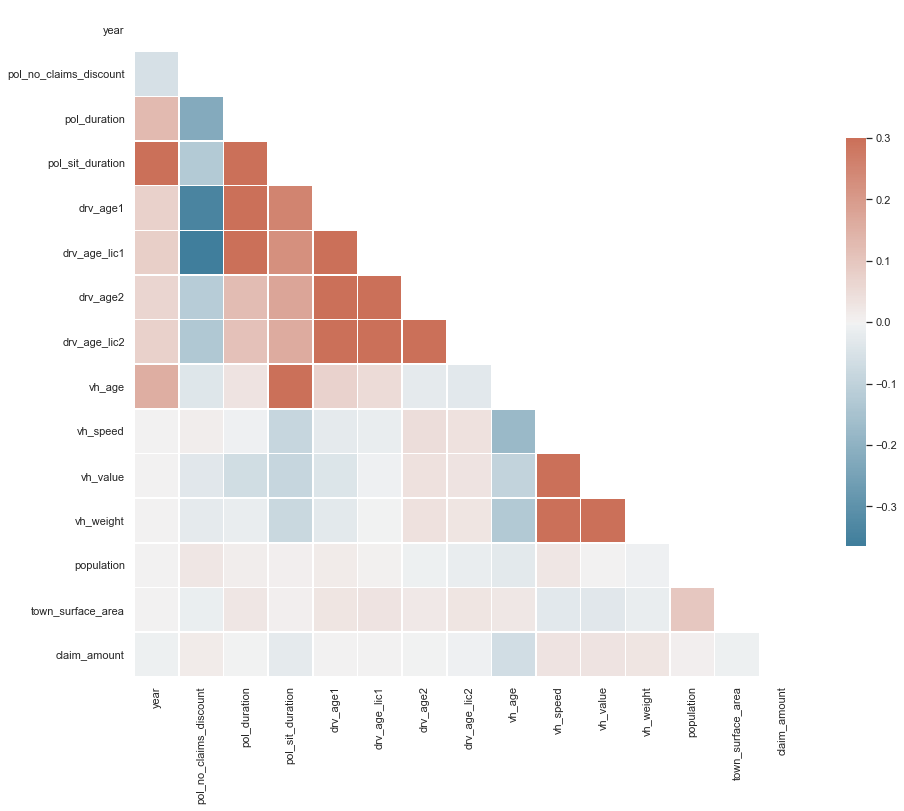

In [11]:
corr = df[non_categorical.index].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Prediction for Important Variables

### Claims time series analysis
Find which year of policy do people claim on

In [12]:
df['claim'] = df['claim_amount'].apply(lambda x: True if x > 0 else False)
claim_policy_df = df[['id_policy','year','claim']]
claim_policy_df_pivot = claim_policy_df.pivot(index='id_policy', columns='year',values='claim')
claim_policy_df_pivot

year,1.0,2.0,3.0,4.0
id_policy,,,,
PL000000,False,False,False,False
PL000001,False,False,False,False
PL000003,False,False,False,False
PL000005,False,False,True,False
PL000007,False,False,False,False
...,...,...,...,...
PL095628,False,True,True,True
PL095631,False,False,False,False
PL095633,False,False,False,False


-> Find number of claims in each year

In [13]:
claim_policy_df_pivot.sum(axis=0)

year
1.0    6280
2.0    6030
3.0    5747
4.0    5235
dtype: int64

Find how many times each person claim within the 4 years

In [14]:
t = claim_policy_df_pivot.sum(axis=1).value_counts()
t

0    38518
1    14440
2     3495
3      542
4       59
dtype: int64

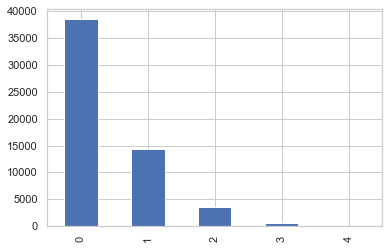

In [15]:
t.plot(kind='bar')